In [ ]:
import os
import zipfile

# Create the kaggle folder and move the json there
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Set permissions
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d puneet6060/intel-image-classification

Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
License(s): copyright-authors
intel-image-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# Re-extract and preserve folder structure
!unzip -o intel-image-classification.zip -d intel_data

Streaming output truncated to the last 5000 lines.
  inflating: intel_data/seg_train/seg_train/mountain/7506.jpg  
  inflating: intel_data/seg_train/seg_train/mountain/7537.jpg  
  inflating: intel_data/seg_train/seg_train/mountain/7539.jpg  
  inflating: intel_data/seg_train/seg_train/mountain/7551.jpg  
  inflating: intel_data/seg_train/seg_train/mountain/7560.jpg  
  inflating: intel_data/seg_train/seg_train/mountain/7565.jpg  
  inflating: intel_data/seg_train/seg_train/mountain/7578.jpg  
  inflating: intel_data/seg_train/seg_train/mountain/7581.jpg  
  inflating: intel_data/seg_train/seg_train/mountain/7586.jpg  
  inflating: intel_data/seg_train/seg_train/mountain/7647.jpg  
  inflating: intel_data/seg_train/seg_train/mountain/7652.jpg  
  inflating: intel_data/seg_train/seg_train/mountain/7654.jpg  
  inflating: intel_data/seg_train/seg_train/mountain/7662.jpg  
  inflating: intel_data/seg_train/seg_train/mountain/767.jpg  
  inflating: intel_data/seg_train/seg_train/mountain/7

In [ ]:
# list extracted files
!ls intel_data

seg_pred  seg_test  seg_train  train


In [ ]:
print(os.listdir("intel_data"))                         # Should show: ['seg_train']
print(os.listdir("intel_data/seg_train/seg_train"))    # Should show: ['buildings', 'forest', 'glacier', ...]

['seg_train', 'train', 'seg_test', 'seg_pred']
['mountain', 'buildings', 'glacier', 'forest', 'street', 'sea']


In [ ]:
#split data into train and test
data_dir = "intel_data/seg_train/seg_train"  # Path to the folder with subfolders per class
img_size = (64, 64)
batch_size = 32

# Training set (80%)
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)

# Test set (20%)
test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)

Found 14034 files belonging to 6 classes.
Using 11228 files for training.
Found 14034 files belonging to 6 classes.
Using 2806 files for validation.
Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [ ]:
# Normalizing images i.e. Preprocessing techniques

import tensorflow as tf

def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0,1]
    return image, label

# Apply preprocessing
train_ds = train_ds.map(preprocess).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.map(preprocess).prefetch(tf.data.AUTOTUNE)


In [ ]:
# Train a CNN

from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 683,974 (2.61 MB)

 Trainable params: 683,974 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Training the model

history = model.fit(train_ds, epochs=10, validation_data=test_ds)

Epoch 1/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 99s 273ms/step - accuracy: 0.4234 - loss: 1.3600 - val_accuracy: 0.6187 - val_loss: 0.9730
Epoch 2/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 96s 274ms/step - accuracy: 0.6282 - loss: 0.9544 - val_accuracy: 0.7003 - val_loss: 0.8081
Epoch 3/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 97s 277ms/step - accuracy: 0.7162 - loss: 0.7894 - val_accuracy: 0.7256 - val_loss: 0.7511
Epoch 4/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 93s 265ms/step - accuracy: 0.7417 - loss: 0.7025 - val_accuracy: 0.7780 - val_loss: 0.6111
Epoch 5/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 90s 257ms/step - accuracy: 0.7654 - loss: 0.6492 - val_accuracy: 0.7480 - val_loss: 0.6679
Epoch 6/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 95s 270ms/step - accuracy: 0.8033 - loss: 0.5580 - val_accuracy: 0.7787 - val_loss: 0.6222
Epoch 7/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 135s 251ms/step - accuracy: 0.8155 - loss: 0.5287 - val_accuracy: 0.7919 - val_loss: 0.5907
Epoch 8/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 87s 247ms/step - accuracy: 0.8335 - loss: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 761ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/ste

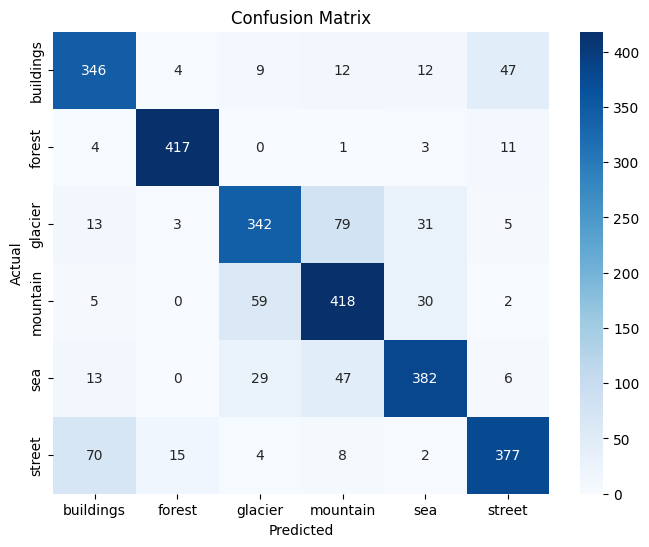

              precision    recall  f1-score   support

   buildings       0.77      0.80      0.79       430
      forest       0.95      0.96      0.95       436
     glacier       0.77      0.72      0.75       473
    mountain       0.74      0.81      0.77       514
         sea       0.83      0.80      0.82       477
      street       0.84      0.79      0.82       476

    accuracy                           0.81      2806
   macro avg       0.82      0.82      0.82      2806
weighted avg       0.81      0.81      0.81      2806



In [11]:
# Evaluation with confusion matrix

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Get true labels and predictions
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(tf.argmax(preds, axis=1).numpy())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_true, y_pred, target_names=class_names))

In [12]:
# saving model
model.save("model.h5")

In [14]:
!pip install streamlit tensorflow pillow numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 59.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 103.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.2 MB/s eta 0:00:00


In [20]:
# building a streamlit app
code='''
import streamlit as st
import tensorflow as tf
from PIL import Image
import numpy as np

# Load model
model = tf.keras.models.load_model("model.h5")

# Define class names (same order as training)
class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

# Page title
st.title("Intel Image Classifier 🌍")
st.write("Upload an image (64x64) and get the predicted class.")

# File uploader
uploaded_file = st.file_uploader("Choose an image...", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    # Display image
    image = Image.open(uploaded_file).convert('RGB')
    st.image(image, caption="Uploaded Image", use_column_width=True)

    # Preprocess image
    img = image.resize((64, 64))
    img_array = np.array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Make prediction
    prediction = model.predict(img_array)
    predicted_class = class_names[np.argmax(prediction)]

    # Show result
    st.success(f"Predicted Class: **{predicted_class}**")
'''

with open("app.py", "w") as f:
  f.write(code)

In [21]:
# downloads files locally
from google.colab import files
files.download("app.py")
files.download("model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>